In [3]:
import torch

In [4]:
import torchvision

In [5]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


In [1]:
import matplotlib.pyplot as plt



In [2]:
import numpy as np

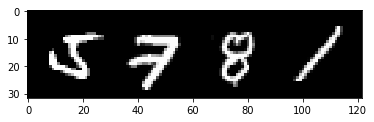

    5     7     8     1


In [6]:

# functions to show an image

classes = [i for i in range(10)]
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
images[0][0][images[0][0]>0.5]

tensor([0.5020, 0.5020, 0.5020, 0.5020, 0.7490, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7490, 0.5020, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5020, 0.5020, 0.5020, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7490, 0.5020, 0.5020, 0.7490, 1.0000, 1.0000, 0.5020, 0.7490, 1.0000,
        1.0000, 0.5020, 1.0000, 1.0000, 0.7490, 1.0000, 0.5020, 1.0000, 1.0000,
        0.5020, 1.0000, 1.0000, 0.5020, 1.0000, 1.0000, 0.7490, 1.0000, 1.0000,
        0.7490, 1.0000, 1.0000, 0.7490, 1.0000, 1.0000, 1.0000, 0.7490, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5020, 0.5020, 1.0000, 1.0000, 0.5020,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5020, 0.7490, 1.0000, 1.0000,
        0.5020, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5020, 0.5020,
        1.0000, 1.0000, 0.5020, 0.7490, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.5020, 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class StochasticLinearLayer:
    from torch.distributions import Normal
    
    def __init__(self, inDim, outDim, activation_f):
        """
        A linear layer that samples its weights from Gaussian distributions every time it runs
        activation_f is an activation function
        """
        self.W_distributions = [[Normal(torch.tensor([0.0]), torch.tensor([1.0])) for i in range(inDim)] for j in range(outDim)]
        self.b_distributions = [Normal(torch.tensor([0.0]), torch.tensor([1.0])) for j in range(outDim)]
        self.activation_f  = activation_f
        
    def prior_w_mu(self, i, j):
        return self.W_distributions[i][j].loc
    
    def prior_w_sigma(self, i, j):
        return self.W_distributions[i][j].scale
    
    def prior_b_mu(self, i):
        return self.b_distributions[i].loc
    
    def prior_b_sigma(self, i):
        return self.b_distributions[i].scale
    
    def forward(self, x):
        current_W_values = torch.tensor([[d.sample() for d in self.W_distributions[i]] for i in range(len(self.distributions))])
        current_b_values = torch.tensor([d.sample() for d in self.b_distributions])
        return activation_f(torch.sum(torch.x*current_W_values) + current_b_value)
        
        
        
        

class Encoder(nn.Module):
    def __init__(self, dims, activations):
        """
        dims is a list of dimensions
        activations is a list of functions, of dimension (len(dims)-1)
        """
        super(Net, self).__init__()
        assert(len(activations)-1 == len(dims))
        self.layers = [StochasticLinearLayer()]
        self.l1 = 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [16]:
from torch.distributions import Normal

In [17]:
m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [19]:
m.loc

tensor([0.])

In [20]:
t = torch.zeros(2)

In [24]:
t = torch.tensor([1, t.unsqueeze()])

TypeError: unsqueeze() missing 1 required positional arguments: "dim"

In [25]:
dir(t)

['__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate_

RuntimeError: shape '[3]' is invalid for input of size 2